In [68]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate, ShuffleSplit
import pandas as pd
import data 

sns.set(style="white")
%matplotlib inline
%load_ext autoreload
%autoreload 2
NUM_PATIENTS = 12044

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
features = data.get_features() # uses several forms
outcomes = data.get_outcomes() # 2 outcomes: iai, and iai_intervention
df = pd.merge(features, outcomes, on='id', how='left')

100%|██████████| 49/49 [00:01<00:00, 34.96it/s]
48it [00:03, 13.37it/s]


final shape (12044, 433)


# make full data matrix

In [70]:
X_feats = data.preprocess(features)
print(X_feats.shape, X_feats.keys())

(12044, 112) Index(['id', 'ageinyrs', 'EDTriageTime_1', 'InjuryDay_1', 'InjTmKnown_1',
       'TriageTmUnkown_1', 'Certification_1', 'LtCostalTender_1',
       'RtCostalTender_1', 'AbnChestAusc_1',
       ...
       'AbdDistention_1_3', 'AbdDistention_1_4', 'AbdTenderDegree_1_1.0',
       'AbdTenderDegree_1_2.0', 'AbdTenderDegree_1_3.0',
       'AbdTenderDegree_1_4.0', 'AbdTenderDegree_1_nan', 'Costal_1_True',
       'AbdTrauma_or_SeatBeltSign_1_False',
       'AbdTrauma_or_SeatBeltSign_1_True'],
      dtype='object', length=112)


In [71]:
X_np = X_feats.values
feature_names = list(X_feats)
y_np = outcomes['iai_intervention']

In [72]:
# X_feats.describe()

# recreate original study

**what variables did they allow?**
- age < 2
- VomitWretch_1: Vomiting/Retching
    1. (Yes)
    2. (No)
    3. (Unknown)
    4. (Not answered)
- RecodedMOI_1: Mechanism of Injury???
    - Note - RecodedMOI reviewed / correct some "Other Mechanisms" in the InjuryMechanism_1 field
    1. Occupant in Motor Vehicle Collision (MVC)
    2. Fall from an elevation
    3. Fall down stairs
    4. Pedestrian or bicyclist struck by moving vehicle 5 - Bike collision or fall from bike while riding
    6. Motorcycle/ATV/Motorized Scooter collision
    7. Object struck abdomen
    8. Unknown mechanism
    9. Other mechanism
    10. Physician did not answer
- hypotension???
- GCSScore_1: Aggregate Glasgow Coma Score
    1. 6:Follow commands
    2. 5:Localizes pain
    3. 4:Withdraws to pain
    4. 3:Abnormal flexure posturing
    5. 2:Abnormal extension posturing 
    6. 1:None
- ThoracicTender_1
    1. Yes
    2. No
    3. Unable to Assess
    4. Physician did not answer
- ThoracicTrauma_1: evidence of thoracic wall trauma
    1. Yes
    2. No
    3. Physician did not answer
- Costal_1: costal margin tenderness
    - constructed from LtCostalTender (and RtCostalTender)
    1. True - either side was tender
    2. False - neighter side was tender
- DecrBreathSound_1: decreased breath sounds
    1. Yes
    2. No
    3. Unknown
    4. Physician did not answer
- AbdDistention_1: abdominal distention
    1. Yes
    2. No
    3. Unknown
    4. Physician did not answer
- AbdomenPain_1: complaints of abdominal pain
    1. Yes
    2. No
    3. Unable to Assess
    4. Physician did not answer
- AbdTenderDegree_1: abdominal tenderness
    1. Mild
    2. Moderate
    3. Severe
    4. Physician did not answer
- evidence of abdominal wall trauma or seat belt sign
    AbdTrauma_1
        1. Yes
        2. No
        3. Unknown
        4. Physician did not answer
    SeatBeltSign_1
        1. Yes
        2. No
        3. Physician did not answer
- DistractingPain_1: distracting painful injury
    1. Yes
    2. No
    3. Unable to Assess
    4. Physician did not answer
- femur fracture

In [73]:
max_depth = 5
m = DecisionTreeClassifier(max_depth=max_depth, class_weight={0: 1, 1: 100})
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
m_cv = cross_validate(m, X_np, y_np, cv=5, scoring=['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'],
                      return_train_score=True, return_estimator=True)

In [74]:
print('metric\ttrain\ttest')
for key in m_cv:
    if 'test' in key:
        print(f"{key.replace('test_', '')}\t{np.mean(m_cv[key.replace('test', 'train')]):0.2f}\t{np.mean(m_cv[key]):0.2f}")
    

metric	train	test
precision	0.09	0.07
recall	0.98	0.73
f1	0.16	0.13
balanced_accuracy	0.90	0.79
roc_auc	0.95	0.83


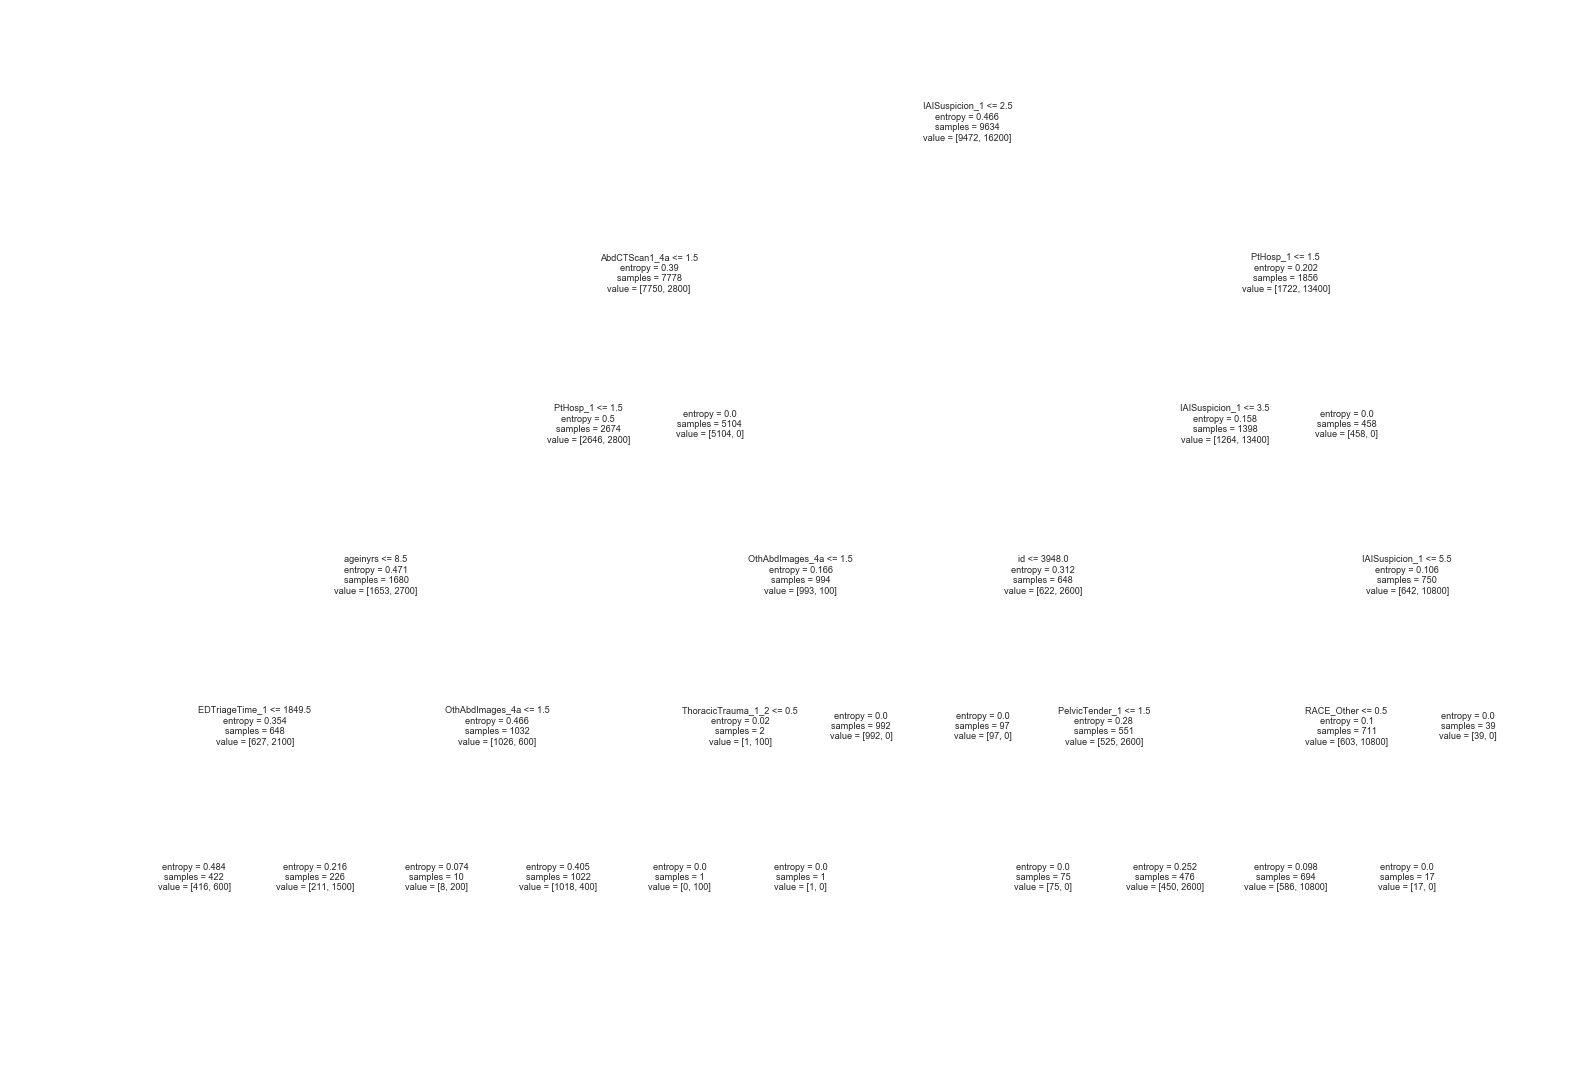

In [75]:
m_fit = m_cv['estimator'][0]
plt.figure(dpi=300)
plot_tree(m_fit, feature_names=feature_names)
plt.show()

In [76]:
# IAISuspicion_1 - Clinical suspicion for the presence of IAI identified on CT (split into 5 levels)
# IAIAcuteInterv_1 - Clinical suspicion for IAI in need of acute intervention (split into 5 levels)

In [77]:
corrs_feat = pd.merge(X_feats, outcomes, on='id', how='left').corr(method='kendall')
cs = corrs_feat.iai_intervention.sort_values(ascending=False)
cs = cs[~cs.isnull()]

# let's look at some important variables

In [78]:
print(cs[:30], cs[-30:])

iai_intervention                    1.000000
IAIAcuteInterv_1                    0.203900
AbdDistention_1_1                   0.190750
AbdTenderDegree_1_3.0               0.182814
IAISuspicion_1                      0.177862
AbdTrauma_1_1                       0.140139
AbdTrauma_or_SeatBeltSign_1_True    0.137807
GCSEye_1                            0.135348
RefuseFU_1                          0.128356
GCSMotor_1                          0.124774
ThoracicTender_1_3                  0.109951
GCSVerbal_1                         0.103195
VomitWretch_1_3                     0.096657
PeritonIrrit_1                      0.094013
DecrBreathSound_1_1                 0.092501
SeatBeltSign_1_1                    0.089327
InitResp_1                          0.075671
AbdomenPain_1_3                     0.072694
FlankTender_1                       0.072100
DistractingPain_1_3                 0.070763
PelvicTender_1                      0.065348
VomitWretch_1_1                     0.064815
AbdomenPai

In [ ]:
corrs_init = df.corr(method='kendall')
cs = corrs.iai_intervention.sort_values(ascending=False)
cs = cs[~cs.isnull()]

print(cs[:30], cs[-30:])

In [ ]:
df.AbdTenderDegree_1.fillna(4)

In [44]:
df.AbdTrauma_1

0        2
1        2
2        2
3        2
4        2
5        1
6        2
7        2
8        2
9        2
10       2
11       2
12       2
13       2
14       2
15       1
16       2
17       1
18       2
19       2
20       2
21       2
22       2
23       1
24       2
25       2
26       2
27       2
28       2
29       2
        ..
12014    2
12015    2
12016    2
12017    2
12018    2
12019    2
12020    2
12021    2
12022    2
12023    2
12024    2
12025    2
12026    2
12027    2
12028    2
12029    1
12030    1
12031    2
12032    2
12033    2
12034    1
12035    2
12036    2
12037    2
12038    2
12039    2
12040    1
12041    2
12042    2
12043    2
Name: AbdTrauma_1, Length: 12044, dtype: int64

In [61]:
df.DistractingPain_1

0        2
1        2
2        1
3        2
4        1
5        2
6        1
7        2
8        2
9        1
10       2
11       2
12       1
13       2
14       2
15       2
16       2
17       2
18       2
19       2
20       1
21       2
22       2
23       2
24       2
25       2
26       2
27       2
28       1
29       2
        ..
12014    3
12015    2
12016    2
12017    2
12018    1
12019    2
12020    1
12021    1
12022    2
12023    1
12024    2
12025    1
12026    2
12027    1
12028    2
12029    2
12030    3
12031    1
12032    2
12033    2
12034    1
12035    2
12036    1
12037    2
12038    2
12039    2
12040    1
12041    2
12042    2
12043    1
Name: DistractingPain_1, Length: 12044, dtype: int64

In [62]:
df.

0        2
1        1
2        2
3        2
4        2
5        3
6        2
7        2
8        2
9        2
10       1
11       3
12       2
13       1
14       2
15       1
16       1
17       1
18       2
19       2
20       2
21       2
22       2
23       1
24       2
25       2
26       1
27       2
28       2
29       1
        ..
12014    3
12015    2
12016    1
12017    1
12018    2
12019    2
12020    1
12021    3
12022    3
12023    2
12024    2
12025    2
12026    2
12027    2
12028    1
12029    3
12030    3
12031    1
12032    2
12033    2
12034    1
12035    3
12036    3
12037    2
12038    3
12039    2
12040    1
12041    1
12042    2
12043    2
Name: AbdomenPain_1, Length: 12044, dtype: int64